In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
data = pd.read_csv("./fraud_order_classifier.csv")

In [3]:
data.dropna(inplace=True)

In [4]:
labels = {"normal": 0, "fraud": 1}
data["label"] = data["label"].map(labels)
data.head(2)

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,category_purchase_count_j9e,category_purchase_count_jek,category_purchase_count_tyy,category_purchase_count_vdm,category_purchase_count_X6bo,category_purchase_count_X2oq,category_purchase_count_mcr,category_purchase_count_osp,category_purchase_count_r18,label
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Time Encoding

In [5]:
# encoding cyclic features
def cyclic_encoding(data, col, max_val):    
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data.drop(col, axis=1)

def time_features(data, column):
    data[column] = pd.to_datetime(data[column], errors='coerce')

    data[f'{column} Year'] = data[column].dt.year
    data[f'{column} Month'] = data[column].dt.month
    
    data[f'{column} Day'] = data[column].dt.day
    data[f'{column} Hour'] = data[column].dt.hour
    data[f'{column} Weekday'] = data[column].dt.dayofweek

    # encode cyclic features
    cols = [("Hour", 24), ("Month", 12), ("Day", 31), ("Weekday", 7)]

    for col, period in cols:
        data = cyclic_encoding(data, f"{column} {col}", period)
    
    return data

In [6]:
date_cols = ["order_date", "user_account_created_date"]

for date_col in date_cols:
    data = time_features(data, date_col)

data.head(2)

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,order_date Weekday_cos,user_account_created_date Year,user_account_created_date Hour_sin,user_account_created_date Hour_cos,user_account_created_date Month_sin,user_account_created_date Month_cos,user_account_created_date Day_sin,user_account_created_date Day_cos,user_account_created_date Weekday_sin,user_account_created_date Weekday_cos
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,...,-0.900969,2012,0.707107,-7.071068e-01,0.866025,-0.5,-0.937752,0.347305,0.974928,-0.222521
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,...,-0.222521,2012,-1.000000,-1.836970e-16,-0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969


In [7]:
data['Duration Days'] = round((data['order_date'] - data['user_account_created_date']) / np.timedelta64(1, 'D'))
data['Duration Months'] = round((data['order_date'] - data['user_account_created_date']) / np.timedelta64(1, 'M'))
data.head(2)

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,user_account_created_date Hour_sin,user_account_created_date Hour_cos,user_account_created_date Month_sin,user_account_created_date Month_cos,user_account_created_date Day_sin,user_account_created_date Day_cos,user_account_created_date Weekday_sin,user_account_created_date Weekday_cos,Duration Days,Duration Months
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,...,0.707107,-7.071068e-01,0.866025,-0.5,-0.937752,0.347305,0.974928,-0.222521,758.0,25.0
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,...,-1.000000,-1.836970e-16,-0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969,655.0,22.0


# Train Test Split

In [8]:
# Train-Test Split
split_ratio = 0.7
msk = np.random.rand(len(data)) < split_ratio

train = data[msk]
test = data[~msk]

print(len(train), len(test))

324034 137869


# Response Encoding

In [9]:
# Response Encoding
def response_encoding(data, column, label="label"):
    value_counts = data.groupby(column)[label].value_counts().reset_index(name="count")

    x = data[[column]].drop_duplicates()
    y = data[[label]].drop_duplicates()

    x["temp"] = 0
    y["temp"] = 0

    temp = pd.merge(x, y, on=["temp"])
    temp.drop(columns=["temp"], inplace=True)
    temp.sort_values(by=[column, label], ascending=True, inplace=True)

    value_counts = temp.merge(value_counts, how="left")
    value_counts.fillna(0, inplace=True)

    numerator = value_counts.groupby(column, sort=False)["count"].apply(np.array)
    denominator = value_counts.groupby(column, sort=False)["count"].sum()
    
    value_counts = (numerator / denominator).apply(lambda x: x.tolist())
    return value_counts.to_dict()


# categorical columns
categorical_columns = ["product_id", "shipping_type", "user_id", "city", "pincode", "vertical"]
categorical_encoding = {column: response_encoding(train, column) for column in tqdm(categorical_columns)}

100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.77it/s]


In [10]:
categorical_encoding["shipping_type"]

{'ndd': [0.8864737406216506, 0.11352625937834941],
 'non-ndd': [0.9589303945009959, 0.04106960549900402]}

# Feature Aggregation

In [11]:
# aggregate features for all categorical columns
def aggregate_categorical_features(data):
    func = lambda column: data[column].map(lambda x: categorical_encoding[column].get(x, [1/2] * 2))

    categorical_features = func(categorical_columns[0])

    for cat_col in categorical_columns[1:]:
        categorical_features += func(cat_col)

    return categorical_features


train_categorical_features = aggregate_categorical_features(train).reset_index(drop=True)
test_categorical_features = aggregate_categorical_features(test).reset_index(drop=True)

test_categorical_features

0         [0.991701244813278, 0.008298755186721992, 0.95...
1         [0.9809582817017761, 0.019041718298223875, 0.9...
2         [0.9953051643192489, 0.004694835680751174, 0.9...
3         [0.9737827715355806, 0.026217228464419477, 0.9...
4         [0.9615384615384616, 0.038461538461538464, 0.8...
                                ...                        
137864    [1.0, 0.0, 0.9589303945009959, 0.0410696054990...
137865    [1.0, 0.0, 0.9589303945009959, 0.0410696054990...
137866    [1.0, 0.0, 0.9589303945009959, 0.0410696054990...
137867    [1.0, 0.0, 0.9589303945009959, 0.0410696054990...
137868    [0.9891304347826086, 0.010869565217391304, 0.9...
Name: product_id, Length: 137869, dtype: object

In [12]:
cyclic_columns = list(data.columns[40:58])
cyclic_columns

['order_date Year',
 'order_date Hour_sin',
 'order_date Hour_cos',
 'order_date Month_sin',
 'order_date Month_cos',
 'order_date Day_sin',
 'order_date Day_cos',
 'order_date Weekday_sin',
 'order_date Weekday_cos',
 'user_account_created_date Year',
 'user_account_created_date Hour_sin',
 'user_account_created_date Hour_cos',
 'user_account_created_date Month_sin',
 'user_account_created_date Month_cos',
 'user_account_created_date Day_sin',
 'user_account_created_date Day_cos',
 'user_account_created_date Weekday_sin',
 'user_account_created_date Weekday_cos']

In [13]:
# list(data.columns[40:58])
feature_columns = data.select_dtypes(include=['float64', 'int64']).columns
feature_columns = feature_columns.drop("label")
numerical_columns = list(feature_columns.difference(cyclic_columns))
numerical_columns

['Duration Days',
 'Duration Months',
 'category_purchase_count_X26x',
 'category_purchase_count_X2oq',
 'category_purchase_count_X4kt',
 'category_purchase_count_X4rr',
 'category_purchase_count_X6bo',
 'category_purchase_count_amz',
 'category_purchase_count_bks',
 'category_purchase_count_ckf',
 'category_purchase_count_dep',
 'category_purchase_count_dgv',
 'category_purchase_count_ixq',
 'category_purchase_count_j9e',
 'category_purchase_count_jek',
 'category_purchase_count_kyh',
 'category_purchase_count_mcr',
 'category_purchase_count_mgl',
 'category_purchase_count_osp',
 'category_purchase_count_r18',
 'category_purchase_count_reh',
 'category_purchase_count_t06',
 'category_purchase_count_tyy',
 'category_purchase_count_vdm',
 'count_14_days',
 'count_28_days',
 'count_56_days',
 'discount',
 'quantity',
 'selling_price']

In [14]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# data

In [15]:
feature_columns = numerical_columns + cyclic_columns

In [16]:
y_train = train["label"]
X_train = pd.Series(train[feature_columns].values.tolist()) + train_categorical_features

y_test = test["label"]
X_test = pd.Series(test[feature_columns].values.tolist()) + test_categorical_features

In [17]:
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

In [18]:
X_train, y_train

(array([[7.58000000e+02, 2.50000000e+01, 0.00000000e+00, ...,
         1.90476190e-02, 9.08734336e-01, 9.12656644e-02],
        [6.55000000e+02, 2.20000000e+01, 0.00000000e+00, ...,
         0.00000000e+00, 5.88899167e-01, 4.11100833e-01],
        [5.85000000e+02, 1.90000000e+01, 0.00000000e+00, ...,
         7.54147813e-03, 9.92672097e-01, 7.32790258e-03],
        ...,
        [6.02000000e+02, 2.00000000e+01, 0.00000000e+00, ...,
         2.34741784e-02, 9.92672097e-01, 7.32790258e-03],
        [6.02000000e+02, 2.00000000e+01, 0.00000000e+00, ...,
         2.34741784e-02, 9.92672097e-01, 7.32790258e-03],
        [1.53000000e+02, 5.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 8.96357106e-01, 1.03642894e-01]]),
 1         0
 2         0
 3         0
 5         0
 6         0
          ..
 481099    0
 481100    0
 481103    0
 481104    0
 481106    0
 Name: label, Length: 324034, dtype: int64)

In [19]:
X_test, y_test

(array([[ 5.85000000e+02,  1.90000000e+01,  0.00000000e+00, ...,
          7.54147813e-03,  9.92672097e-01,  7.32790258e-03],
        [-1.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
          3.57142857e-02,  9.08734336e-01,  9.12656644e-02],
        [ 4.25000000e+02,  1.40000000e+01,  0.00000000e+00, ...,
          8.44510681e-03,  9.92672097e-01,  7.32790258e-03],
        ...,
        [ 8.95000000e+02,  2.90000000e+01,  0.00000000e+00, ...,
          1.86046512e-02,  9.92677824e-01,  7.32217573e-03],
        [ 4.36000000e+02,  1.40000000e+01,  0.00000000e+00, ...,
          1.54241645e-02,  9.92672097e-01,  7.32790258e-03],
        [ 2.84000000e+02,  9.00000000e+00,  0.00000000e+00, ...,
          3.33333333e-02,  9.93034393e-01,  6.96560731e-03]]),
 4         0
 13        0
 16        0
 17        0
 20        0
          ..
 481094    0
 481098    0
 481101    0
 481102    0
 481105    0
 Name: label, Length: 137869, dtype: int64)

# Sampling for class imbalance (SMOTE)

In [20]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [21]:
counter = Counter(y_train)
counter

Counter({0: 309036, 1: 14998})

In [22]:
under = RandomUnderSampler(sampling_strategy={0: 200000})
over = SMOTE(sampling_strategy={1: 30000})

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train)
counter

Counter({0: 200000, 1: 30000})

# Modelling

In [23]:
from sklearn import metrics
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

In [24]:
def plot_roc_curve(model):
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc}")
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [32]:
def model_stats(model):
    # Training Accuracy
    dtrain_predictions = model.predict(X_train)

    print("\nModel Report")
    print("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))

    # Testing Accuracy
    dtest_predictions = model.predict(X_test)

    print("\nModel Report")
    print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, dtest_predictions))

    # F1 Score
    print("\n")
    print ("The train f1 score is:", f1_score(y_train, dtrain_predictions, average='weighted'))
    print("The test f1 score is:", f1_score(y_test, dtest_predictions, average='weighted'))

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test, dtest_predictions).ravel()
    print(f"True Negative: {tn}, False Positive: {fp}, False Negative: {fn}, True Positive: {tp}")
    
    # plot ROC
    plot_roc_curve(model)

# XGBoost 

In [26]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [27]:
# Training with best parameters
x_cfl = XGBClassifier(objective='multi:softmax',
                      num_class=2,
                      colsample_bytree=1,
                      learning_rate=0.15,
                      max_depth=20,
                      n_estimators=1000,
                      subsample=0.3)

x_cfl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)


Model Report
Train Accuracy : 1

Model Report
Test Accuracy : 0.8986


The train f1 score is: 0.9999956522047094
The test f1 score is: 0.9201862444749797
True Negative: 118790, False Positive: 12681, False Negative: 1297, True Positive: 5101
AUC: 0.9336172814432666


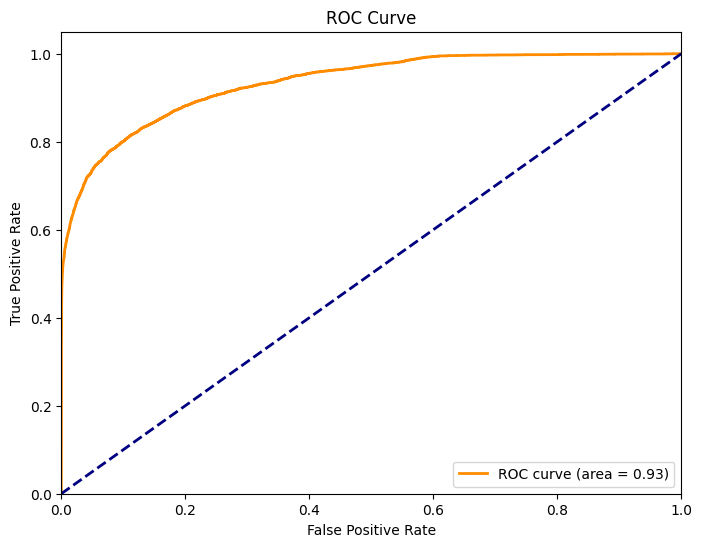

In [33]:
model_stats(x_cfl)

# Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rf = RandomForestClassifier(n_jobs=-1,
                            bootstrap=True,
                            n_estimators=1000,
                            max_depth=20,
                            class_weight='balanced')

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=1000,
                       n_jobs=-1)


Model Report
Train Accuracy : 1

Model Report
Test Accuracy : 0.8236


The train f1 score is: 1.0
The test f1 score is: 0.871350847924707
True Negative: 108291, False Positive: 23180, False Negative: 1137, True Positive: 5261
AUC: 0.9287896966351094


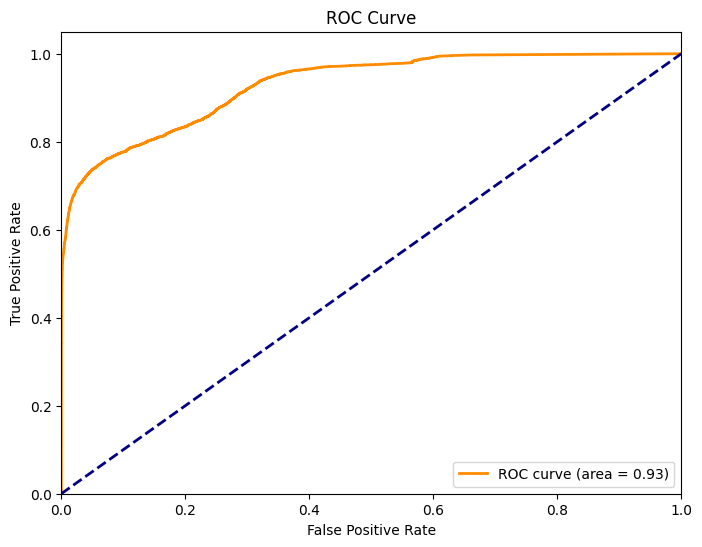

In [36]:
model_stats(rf) 

# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lreg = LogisticRegression(C=100)
lreg.fit(X_train,y_train)

/Users/dawn/git/vision/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)


Model Report
Train Accuracy : 0.879

Model Report
Test Accuracy : 0.9468


The train f1 score is: 0.848358159280433
The test f1 score is: 0.9386399853674903
True Negative: 129338, False Positive: 2133, False Negative: 5208, True Positive: 1190
AUC: 0.8679310260435881


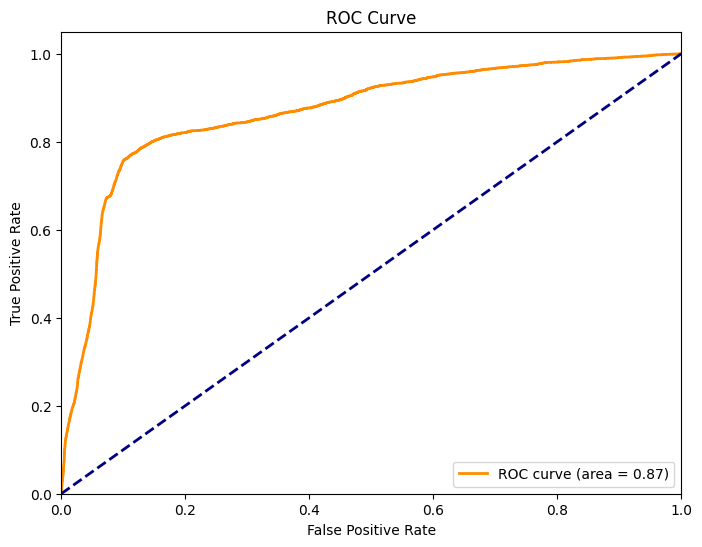

In [39]:
model_stats(lreg)

# MLP

In [40]:
import os
import math
import warnings
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")
torch.manual_seed(0)

In [41]:
class CDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        features = self.x[idx]
        target = self.y[idx]

        return torch.tensor(features, dtype=torch.float32), torch.LongTensor([target])
        
    
from torch.utils.data import DataLoader, random_split


BATCH_SIZE = 64
cdata_train = CDataset(X_train, np.array(y_train))
cdata_test = CDataset(X_test, np.array(y_test))

# train dataloader
train_dataloader_args =  dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=0)
trainloader = DataLoader(cdata_train, pin_memory=True, **train_dataloader_args)

# test dataloader
test_dataloader_args = dict(shuffle=False, batch_size=5000, num_workers=0)
testloader = DataLoader(cdata_test, pin_memory=True, **test_dataloader_args)

In [42]:
cdata_test[0]

(tensor([ 5.8500e+02,  1.9000e+01,  0.0000e+00,  7.0000e+00,  0.0000e+00,
          1.0000e+00,  3.0000e+00,  0.0000e+00,  6.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  2.0000e+00,
          2.0000e+00,  2.6000e+01,  1.6000e+01,  0.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  3.5119e+01,  1.0000e+00,  1.4700e+02,
          2.0140e+03,  0.0000e+00,  1.0000e+00,  5.0000e-01, -8.6603e-01,
         -7.2479e-01,  6.8897e-01,  7.8183e-01,  6.2349e-01,  2.0120e+03,
          0.0000e+00,  1.0000e+00, -8.6603e-01,  5.0000e-01, -6.5137e-01,
         -7.5876e-01, -4.3388e-01, -9.0097e-01,  9.9170e-01,  8.2988e-03,
          9.5893e-01,  4.1070e-02,  1.0000e+00,  0.0000e+00,  9.8072e-01,
          1.9278e-02,  9.9246e-01,  7.5415e-03,  9.9267e-01,  7.3279e-03]),
 tensor([0]))

In [43]:
len(cdata_train[0][0])

60

In [44]:
class FeedForwardNet(nn.Module):
    def __init__(self, ndimension, ntarget, dropout=0.1):
        super().__init__()
        layer1 = self._get_layer(ndimension, 64, dropout)
        layer2 = self._get_layer(64, 32, dropout)
        layer3 = nn.Linear(32, ntarget, bias=False)
        
        self.layer = nn.Sequential(*[layer1, layer2, layer3])
        
    def _get_layer(self, in_dim, out_dim, dropout=0.1):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, input_vec):
        return self.layer(input_vec)

In [45]:
device = torch.device("mps")
model = FeedForwardNet(ndimension=60, ntarget=2, dropout=0.2).to(device)

In [46]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [47]:
def train(epoch, model, device, trainloader, optimizer):
    model.train()

    running_loss = 0
    running_accuracy = 0
    
    iterator = 0
    correct = 0
    processed = 0
    pbar = tqdm(trainloader)

    for i, (src, trg) in enumerate(pbar, 0):
        src, trg = src.to(device), trg.squeeze(-1).to(device)

        output = model(src.float())

        loss = criterion(output, trg)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        pred = output.argmax(-1)
        correct += pred.eq(trg.view_as(pred)).sum().item()
        processed += len(pred)
        
        running_loss += loss.item()
        
    print("Train Epoch - {epoch}, Mini Batch - {batch}, Train Loss - {loss}, Train Accuracy - {accuracy}".format(
                epoch=epoch + 1,
                batch=i + 1,
                loss=round(running_loss / (i+1), 4),
                accuracy=round(100 * correct / processed, 4)
            )
         )

In [48]:
def test(model, device, testloader):
    model.eval()

    iterator = 0
    test_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(testloader, disable=True)

    with torch.no_grad():
        for i, (src, trg) in enumerate(pbar, 0):
            src, trg = src.to(device), trg.squeeze(-1).to(device)

            output = model(src.float())

            loss = criterion(output, trg)
            test_loss += loss.item()
            
            pred = output.argmax(-1)
            correct += pred.eq(trg.view_as(pred)).sum().item()
            processed += len(pred)

        print("Test Loss - {loss}, Test Accuracy - {accuracy}".format(
                    loss=round(test_loss / (i+1), 4),
                    accuracy=round(100 * correct / processed, 4)
             )
        )

In [49]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train(epoch, model, device, trainloader, optimizer)
    test(model, device, testloader)

100%|██████████████████████████████████████████████████████████| 3594/3594 [00:14<00:00, 256.44it/s]


Train Epoch - 1, Mini Batch - 3594, Train Loss - 4.5393, Train Accuracy - 81.2039
Test Loss - 0.2471, Test Accuracy - 95.178


100%|██████████████████████████████████████████████████████████| 3594/3594 [00:13<00:00, 263.42it/s]


Train Epoch - 2, Mini Batch - 3594, Train Loss - 0.3505, Train Accuracy - 86.4387
Test Loss - 0.1969, Test Accuracy - 94.7211


100%|██████████████████████████████████████████████████████████| 3594/3594 [00:13<00:00, 260.20it/s]


Train Epoch - 3, Mini Batch - 3594, Train Loss - 0.3033, Train Accuracy - 87.0052
Test Loss - 0.1898, Test Accuracy - 95.7365


100%|██████████████████████████████████████████████████████████| 3594/3594 [00:14<00:00, 251.97it/s]


Train Epoch - 4, Mini Batch - 3594, Train Loss - 0.2821, Train Accuracy - 88.1148
Test Loss - 0.1603, Test Accuracy - 95.5639


100%|██████████████████████████████████████████████████████████| 3594/3594 [00:13<00:00, 260.08it/s]


Train Epoch - 5, Mini Batch - 3594, Train Loss - 0.2488, Train Accuracy - 90.353
Test Loss - 0.1458, Test Accuracy - 95.3702


In [50]:
def infer(model, device, testloader):
    model.eval()

    pbar = tqdm(testloader)
    
    prediction = []

    with torch.no_grad():
        for i, (src, trg) in enumerate(pbar, 0):
            src, trg = src.to(device), trg.squeeze(-1).to(device)

            output = model(src.float())         
            prediction.extend(output.argmax(-1).tolist())
            
    return np.array(prediction)

In [51]:
dtest_predictions = infer(model, device, testloader)

print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtest_predictions))

100%|███████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 25.94it/s]


Model Report
Accuracy : 0.9537


In [52]:
print("The test f1 score is:", f1_score(y_test, dtest_predictions, average='weighted'))

The test f1 score is: 0.954876604698814


In [53]:
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, dtest_predictions).ravel()
print(f"True Negative: {tn}, False Positive: {fp}, False Negative: {fn}, True Positive: {tp}")

True Negative: 127918, False Positive: 3553, False Negative: 2830, True Positive: 3568


# Conclusion

In [76]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Test Accuracy", "Test F1 Score"]

x.add_row(["Random Forest Classifier", "86.02 %", "89.5 %"])
x.add_row(["XGBoost", "89.31 %", "91.68 %"])
x.add_row(["Logistic Regression", "94.72 %", "93.9 %"])
x.add_row(["MLP", "95.87 %", "96.06 %"])

print(x)

+--------------------------+---------------+---------------+
|          Model           | Test Accuracy | Test F1 Score |
+--------------------------+---------------+---------------+
| Random Forest Classifier |    86.02 %    |     89.5 %    |
|         XGBoost          |    89.31 %    |    91.68 %    |
|   Logistic Regression    |    94.72 %    |     93.9 %    |
|           MLP            |    95.87 %    |    96.06 %    |
+--------------------------+---------------+---------------+
